## Season-based RFM - minmax scaling

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import numpy as np

# Generate the cubehelix color palette
# colors = sns.cubehelix_palette(k, start=0.5, rot=-0.75, dark=0.3, light=0.7, reverse=True, as_cmap=False)
colors = sns.color_palette("tab10")

In [2]:
rfm_all = pd.read_csv('data/data-trans/final_rfm.csv', low_memory=False)
# rfm_fc = pd.read_csv('data/data-trans/rfm_fc.csv', low_memory=False)
# rfm_ec = pd.read_csv('data/data-trans/rfm_ec.csv', low_memory=False)
# rfm_t = pd.read_csv('data/data-trans/rfm_t.csv', low_memory=False)

rfm_all.drop(columns=['average_purchase_fc','average_purchase_ec','average_purchase_t'], inplace=True)

In [3]:
# remove outlier
rfm_all = rfm_all[rfm_all['bid']!=49880]

# rfm_fc = rfm_fc[rfm_fc['bid']!=49880]
# rfm_ec = rfm_ec[rfm_ec['bid']!=49880]
# rfm_t = rfm_t[rfm_t['bid']!=49880]

In [4]:
rfm_all

,bid,recency_t,frequency_t,monetary_t,recency_fc,frequency_fc,monetary_fc,recency_ec,frequency_ec,monetary_ec
0,3551.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,5.0,52425.0
1,3552.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,23.0,283125.0
2,3553.0,0.0,6.0,39600.0,3.0,2.0,6540.0,3.0,11.0,63395.0
3,3554.0,1.0,7.0,9000.0,NaN,NaN,NaN,3.0,2.0,7306.0
4,3555.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,7.0,19805.0
...,...,...,...,...,...,...,...,...,...,...
123165,161739.0,1.0,1.0,3500.0,NaN,NaN,NaN,NaN,NaN,NaN
123166,161740.0,0.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
123167,161741.0,0.0,2.0,7800.0,NaN,NaN,NaN,NaN,NaN,NaN
123168,161742.0,0.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


### RFM preprocessing & standardization

In [5]:
# handle null
# recency = 8
# monetary & frequency = 0
fill_value = {'recency_fc':8, 'recency_ec':8, 'recency_t':8, 'frequency_fc':0,'frequency_ec':0,'frequency_t':0,'monetary_fc':0,'monetary_ec':0,'monetary_t':0}
rfm_filled = rfm_all.fillna(fill_value)


In [22]:
rfm_fc = rfm_filled[['bid','recency_fc','frequency_fc','monetary_fc']]
rfm_t = rfm_filled[['bid','recency_t','frequency_t','monetary_t']]
rfm_ec = rfm_filled[['bid','recency_ec','frequency_ec','monetary_ec']]

In [17]:
rfm_filled.sample(n=10)

,bid,recency_t,frequency_t,monetary_t,recency_fc,frequency_fc,monetary_fc,recency_ec,frequency_ec,monetary_ec
105296,142441.0,0.0,4.0,3000.0,8.0,0.0,0.0,8.0,0.0,0.0
48761,85880.0,2.0,4.0,12000.0,8.0,0.0,0.0,8.0,0.0,0.0
3211,6762.0,8.0,0.0,0.0,8.0,0.0,0.0,2.0,1.0,5665.0
11141,48147.0,8.0,0.0,0.0,1.0,3.0,9290.0,8.0,0.0,0.0
16593,53599.0,8.0,0.0,0.0,0.0,2.0,0.0,8.0,0.0,0.0
87383,124520.0,1.0,1.0,0.0,8.0,0.0,0.0,8.0,0.0,0.0
23911,61016.0,3.0,2.0,6000.0,8.0,0.0,0.0,8.0,0.0,0.0
51524,88645.0,2.0,2.0,0.0,8.0,0.0,0.0,8.0,0.0,0.0
120346,158920.0,0.0,1.0,0.0,8.0,0.0,0.0,8.0,0.0,0.0
67934,105063.0,0.0,5.0,0.0,8.0,0.0,0.0,8.0,0.0,0.0


In [23]:
minmax_scaler = MinMaxScaler()
log_scaler = FunctionTransformer(np.log1p, validate=True)


In [24]:
rfm_filled_scale = rfm_filled.copy()
rfm_fc_scale = rfm_fc.copy()
rfm_ec_scale = rfm_ec.copy()
rfm_t_scale = rfm_t.copy()


rfm_fc_scale[['recency_fc','frequency_fc','monetary_fc']] = minmax_scaler.fit_transform(rfm_fc[['recency_fc','frequency_fc','monetary_fc']])
rfm_ec_scale[['recency_ec','frequency_ec','monetary_ec']] = minmax_scaler.fit_transform(rfm_ec[['recency_ec','frequency_ec','monetary_ec']])
rfm_t_scale[['recency_t','frequency_t','monetary_t']] = minmax_scaler.fit_transform(rfm_t[['recency_t','frequency_t','monetary_t']])

# minmax scale for recency and frequency; log scale for monetary
# rfm_fc_scale[['recency_fc','frequency_fc']] = minmax_scaler.fit_transform(rfm_fc[['recency_fc','frequency_fc']])
# rfm_fc_scale[['monetary_fc']] = log_scaler.fit_transform(rfm_fc[['monetary_fc']])
# rfm_ec_scale[['recency_ec','frequency_ec']] = minmax_scaler.fit_transform(rfm_ec[['recency_ec','frequency_ec']])
# rfm_ec_scale[['monetary_ec']] = log_scaler.fit_transform(rfm_ec[['monetary_ec']])
# rfm_t_scale[['recency_t','frequency_t']] = minmax_scaler.fit_transform(rfm_t[['recency_t','frequency_t']])
# rfm_t_scale[['monetary_t']] = log_scaler.fit_transform(rfm_t[['monetary_t']])

In [25]:
rfm_filled_scale.head()

,bid,recency_t,frequency_t,monetary_t,recency_fc,frequency_fc,monetary_fc,recency_ec,frequency_ec,monetary_ec
0,3551.0,1.000,0.000000,0.000000,1.000,0.000000,0.000000,0.250,0.021739,0.011739
1,3552.0,1.000,0.000000,0.000000,1.000,0.000000,0.000000,0.250,0.100000,0.063396
2,3553.0,0.000,0.003612,0.001672,0.375,0.333333,0.044764,0.375,0.047826,0.014195
3,3554.0,0.125,0.004214,0.000380,1.000,0.000000,0.000000,0.375,0.008696,0.001636
4,3555.0,1.000,0.000000,0.000000,1.000,0.000000,0.000000,0.000,0.030435,0.004435


In [26]:
rfm_fc_scale.head()

,bid,recency_fc,frequency_fc,monetary_fc
0,3551.0,1.000,0.000000,0.000000
1,3552.0,1.000,0.000000,0.000000
2,3553.0,0.375,0.333333,0.044764
3,3554.0,1.000,0.000000,0.000000
4,3555.0,1.000,0.000000,0.000000


### Modeling

#### Functions

##### silhouette scores and inertia

In [27]:
def inertia(df, category):
    # Determine the optimal number of clusters using the elbow method
    inertia = []
    silhouette_scores = []
    K = range(2, 10)
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(df[[f'recency_{category}',f'frequency_{category}',f'monetary_{category}']])
        inertia.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(df[[f'recency_{category}',f'frequency_{category}',f'monetary_{category}']], kmeans.labels_))

    # Create subplots with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Plot the elbow curve
    ax1.plot(K, inertia, 'bo-')
    ax1.set_xlabel('Number of clusters')
    ax1.set_ylabel('Inertia')
    ax1.set_title(f'Elbow Method For Optimal k (RFM-{category})')

    # Plot the silhouette scores
    ax2.plot(K, silhouette_scores, 'bo-')
    ax2.set_xlabel('Number of clusters')
    ax2.set_ylabel('Silhouette Score')
    ax2.set_title(f'Silhouette Method For Optimal k (RFM-{category})')

    plt.suptitle((f"Inertia and silhouette scores (RFM-{category})"),
                fontsize=14, fontweight='bold')
                
    # Adjust layout
    plt.tight_layout()
    plt.show()


##### Drawing graph


In [28]:

def drawing_graph(num_optimal, df, category):
    # Data (replace with your actual data)
    # rfm_fc should be your DataFrame containing the features ['recency_fc', 'frequency_fc', 'monetary_fc', 'average_purchase_fc']

    # Number of clusters (replace with the optimal number of clusters you found)
    optimal_clusters = num_optimal

    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The silhouette coefficient can range from -1, 1 but in practice, will be between -0.1 and 1
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette plots of individual clusters
    ax1.set_ylim([0, len(df) + (optimal_clusters + 1) * 10])

    # Initialize the clusterer with optimal number of clusters and a random generator seed for reproducibility
    clusterer = KMeans(n_clusters=optimal_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(df[[f'recency_{category}',f'frequency_{category}',f'monetary_{category}']])

    # The silhouette_score gives the average value for all the samples
    silhouette_avg = silhouette_score(df[[f'recency_{category}',f'frequency_{category}',f'monetary_{category}']], cluster_labels)
    print(f"For n_clusters = {optimal_clusters}, the average silhouette_score is : {silhouette_avg}")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df[[f'recency_{category}',f'frequency_{category}',f'monetary_{category}']], cluster_labels)

    # Generate the color palette
    # colors = sns.cubehelix_palette(optimal_clusters, start=0.5, rot=-0.75, dark=0.3, light=0.7, reverse=True)
    colors = sns.color_palette("tab10")

    y_lower = 10
    # colors = sns.color_palette('Set2', optimal_clusters)
    for i in range(optimal_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        # color = cm.nipy_spectral(float(i) / optimal_clusters)
        color = colors[i]
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers in the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks(np.arange(-0.1, 1.1, 0.2))

    # 2nd Plot showing the actual clusters formed
    # colors = cm.nipy_spectral(cluster_labels.astype(float) / optimal_clusters)
    # ax2.scatter(df[f'recency_{category}'], df[f'monetary_{category}'], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')
    ax2.scatter(df[f'recency_{category}'], df[f'monetary_{category}'], marker='.', s=30, lw=0, alpha=0.7, c=[colors[label] for label in cluster_labels], edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o', c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature - recency")
    ax2.set_ylabel("Feature space for the 2nd feature - monetary")

    plt.suptitle((f"Silhouette analysis for KMeans clustering on sample data with k_clusters = %d (RFM-{category})" % optimal_clusters),
                fontsize=14, fontweight='bold')

    plt.show()

    return cluster_labels


##### Kmeans FC

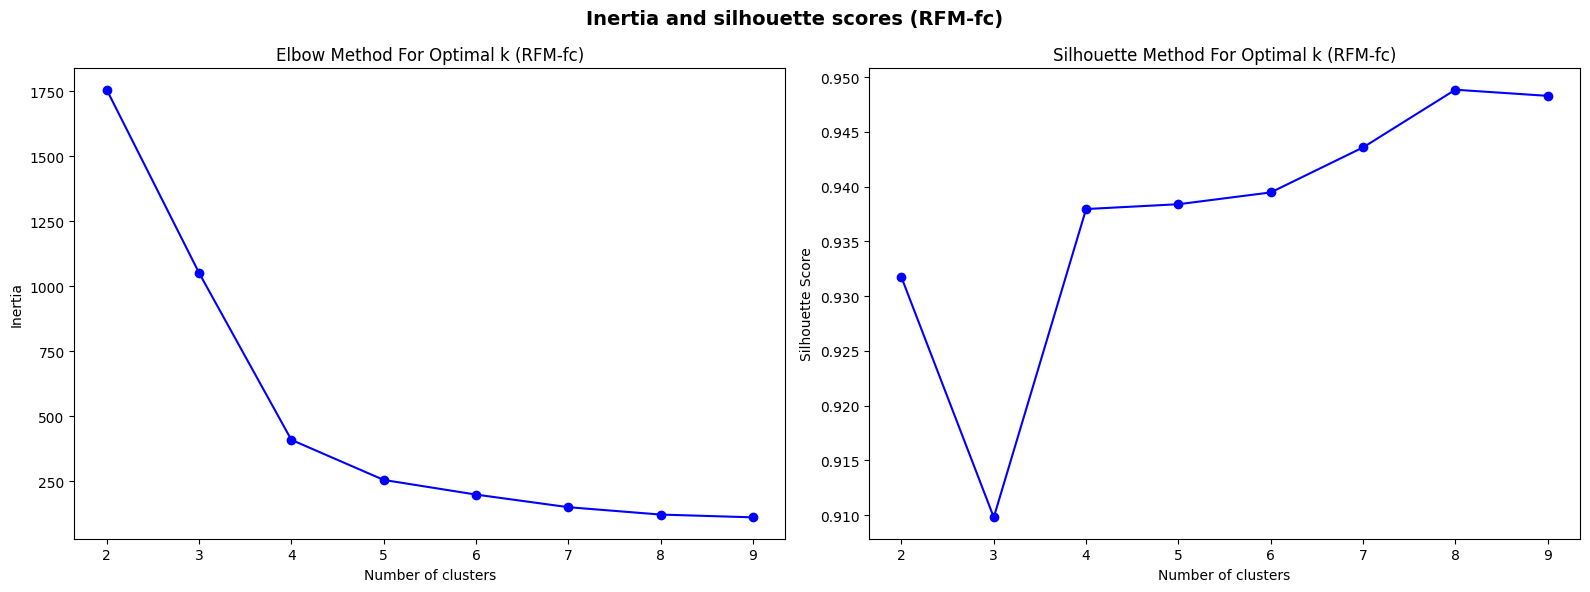

In [29]:
inertia(rfm_fc_scale, 'fc')

For n_clusters = 5, the average silhouette_score is : 0.938403468455626


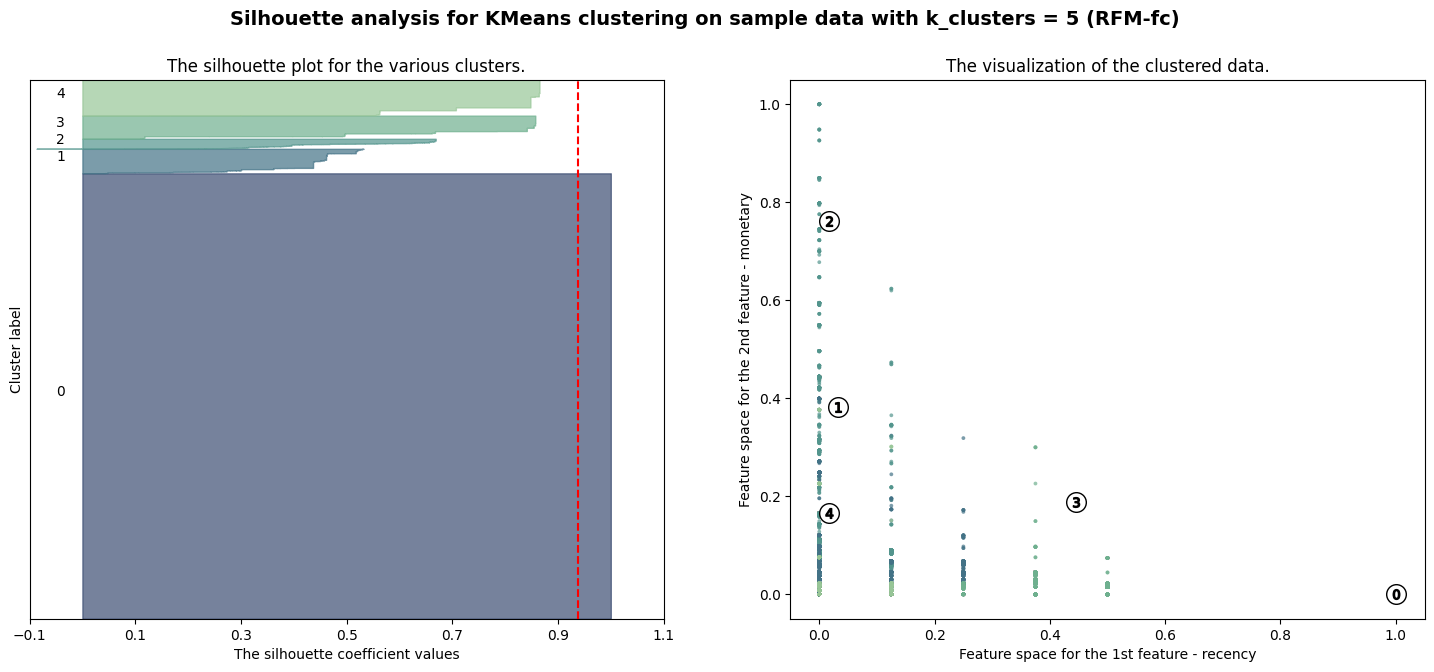

In [30]:
k=5
cluster_labels = drawing_graph(k, rfm_fc_scale, 'fc')

In [31]:
# Assuming the optimal number of clusters is determined to be 5
# kmeans = KMeans(n_clusters=5, random_state=42)
rfm_fc['cluster_fc'] = cluster_labels
rfm_fc_scale['cluster_fc'] = rfm_fc['cluster_fc']
rfm_filled['cluster_fc'] = rfm_fc['cluster_fc']

# Analyze clusters, e.g., calculate mean RFM values for each cluster
cluster_analysis = rfm_fc.groupby('cluster_fc').mean()

# Print cluster analysis results
print(cluster_analysis)

                      bid  recency_fc  frequency_fc   monetary_fc
cluster_fc                                                       
0           108072.736574    8.000000      0.000000      0.000000
1            43392.409716    0.256832      2.291838   6475.225933
2            27085.949234    0.128665      4.573304  26346.722101
3            43371.385387    3.566156      1.124361   2950.283930
4            59510.074273    0.138774      1.000000   3036.489128


C:\Users\seoye\AppData\Local\Temp\ipykernel_332\3906462177.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_fc['cluster_fc'] = cluster_labels


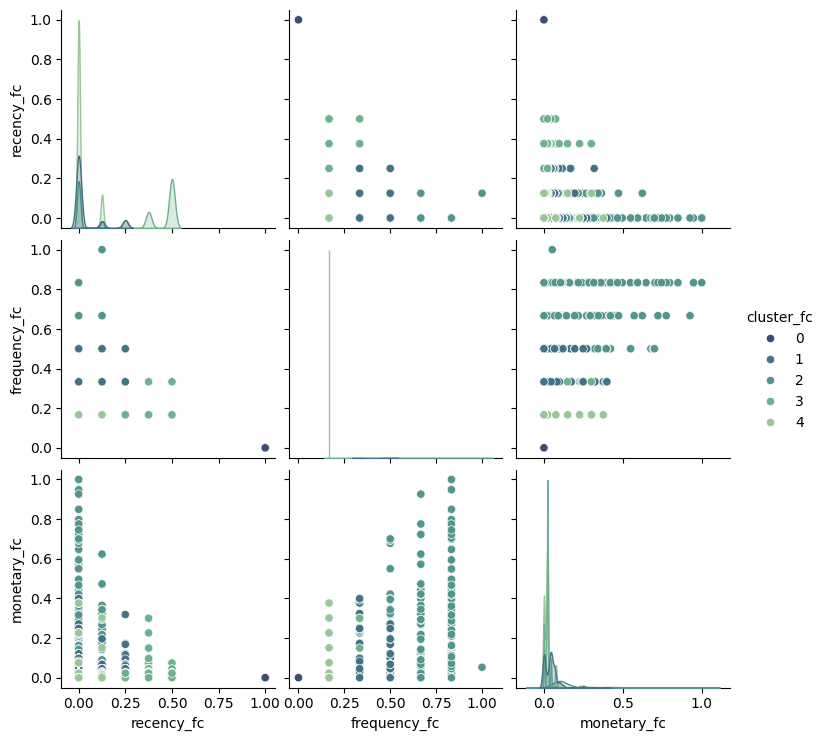

In [32]:


# Visualize clusters
sns.pairplot(rfm_fc_scale, hue='cluster_fc', vars=['recency_fc', 'frequency_fc', 'monetary_fc'], palette=colors)
plt.show()

In [33]:
rfm_fc

,bid,recency_fc,frequency_fc,monetary_fc,cluster_fc
0,3551.0,8.0,0.0,0.0,0
1,3552.0,8.0,0.0,0.0,0
2,3553.0,3.0,2.0,6540.0,3
3,3554.0,8.0,0.0,0.0,0
4,3555.0,8.0,0.0,0.0,0
...,...,...,...,...,...
123165,161739.0,8.0,0.0,0.0,0
123166,161740.0,8.0,0.0,0.0,0
123167,161741.0,8.0,0.0,0.0,0
123168,161742.0,8.0,0.0,0.0,0


##### Kmeans ec

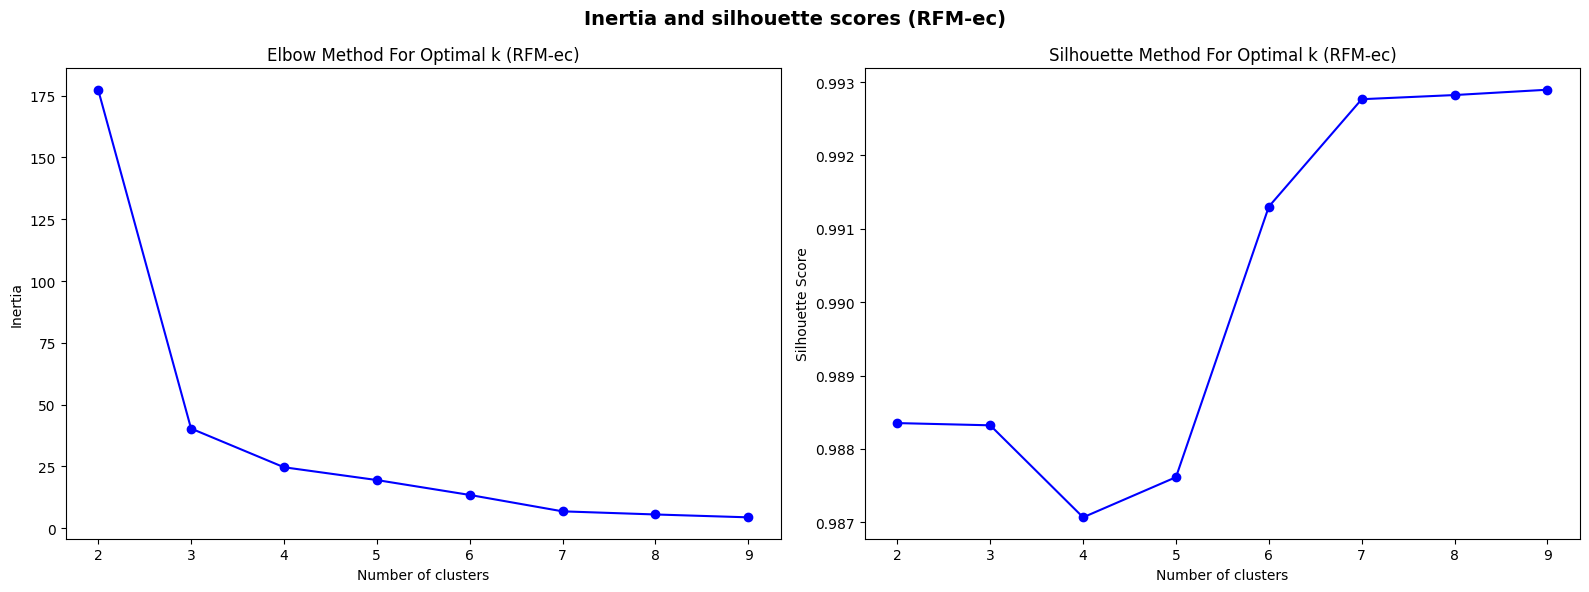

In [34]:
inertia(rfm_ec_scale, 'ec')

For n_clusters = 6, the average silhouette_score is : 0.9913031704021567


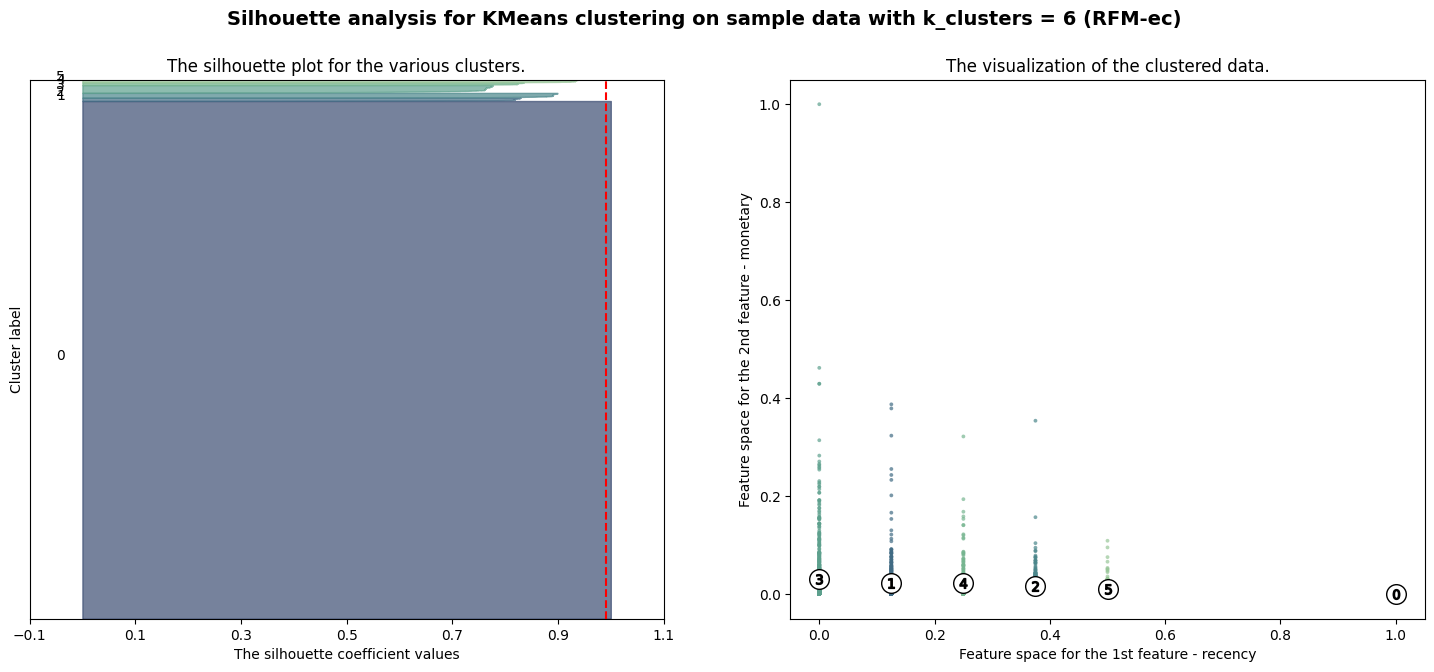

In [35]:
k=6
cluster_labels = drawing_graph(k, rfm_ec_scale, 'ec')


In [36]:
# Assuming the optimal number of clusters is determined to be 5
# kmeans = KMeans(n_clusters=5, random_state=42)
rfm_ec['cluster_ec'] = cluster_labels
rfm_ec_scale['cluster_ec'] = rfm_ec['cluster_ec']
rfm_filled['cluster_ec'] = rfm_ec['cluster_ec']

# Analyze clusters, e.g., calculate mean RFM values for each cluster
cluster_analysis = rfm_ec.groupby('cluster_ec').mean()

# Print cluster analysis results
print(cluster_analysis)

                      bid  recency_ec  frequency_ec   monetary_ec
cluster_ec                                                       
0           101117.382638         8.0      0.000000      0.000000
1             6183.654891         1.0      5.313859  63552.411685
2             5091.108597         3.0      3.641629  33027.984615
3            22461.986479         0.0      6.930704  77634.832676
4             5600.573798         2.0      5.338308  53417.625207
5             5054.769492         4.0      2.462712  24016.759322


C:\Users\seoye\AppData\Local\Temp\ipykernel_332\3331148167.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_ec['cluster_ec'] = cluster_labels


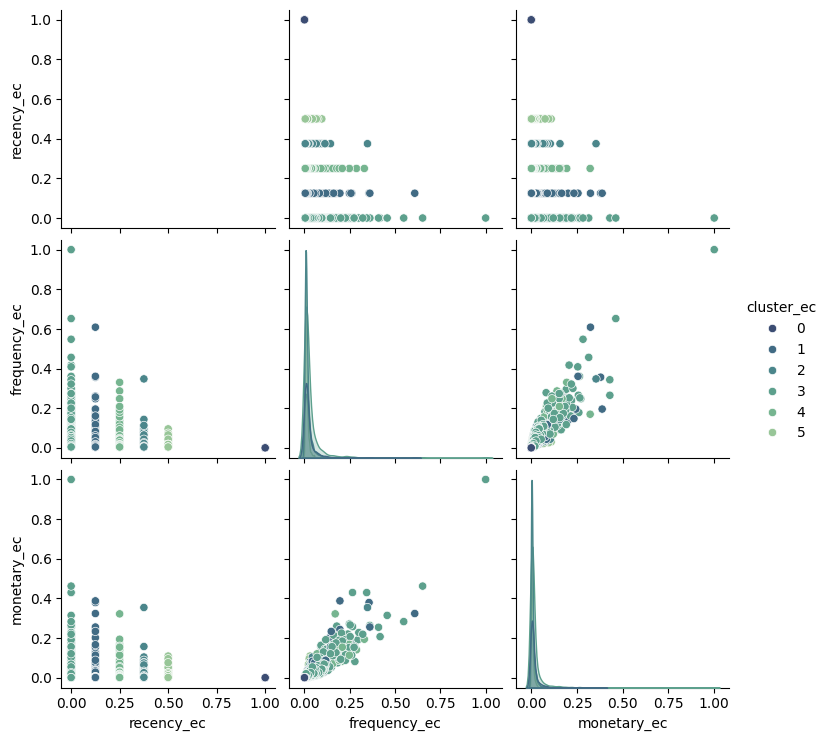

In [37]:


# Visualize clusters
sns.pairplot(rfm_ec_scale, hue='cluster_ec', vars=['recency_ec', 'frequency_ec', 'monetary_ec'], palette=colors)
plt.show()

In [38]:
rfm_ec

,bid,recency_ec,frequency_ec,monetary_ec,cluster_ec
0,3551.0,2.0,5.0,52425.0,4
1,3552.0,2.0,23.0,283125.0,4
2,3553.0,3.0,11.0,63395.0,2
3,3554.0,3.0,2.0,7306.0,2
4,3555.0,0.0,7.0,19805.0,3
...,...,...,...,...,...
123165,161739.0,8.0,0.0,0.0,0
123166,161740.0,8.0,0.0,0.0,0
123167,161741.0,8.0,0.0,0.0,0
123168,161742.0,8.0,0.0,0.0,0


##### Kmeans t

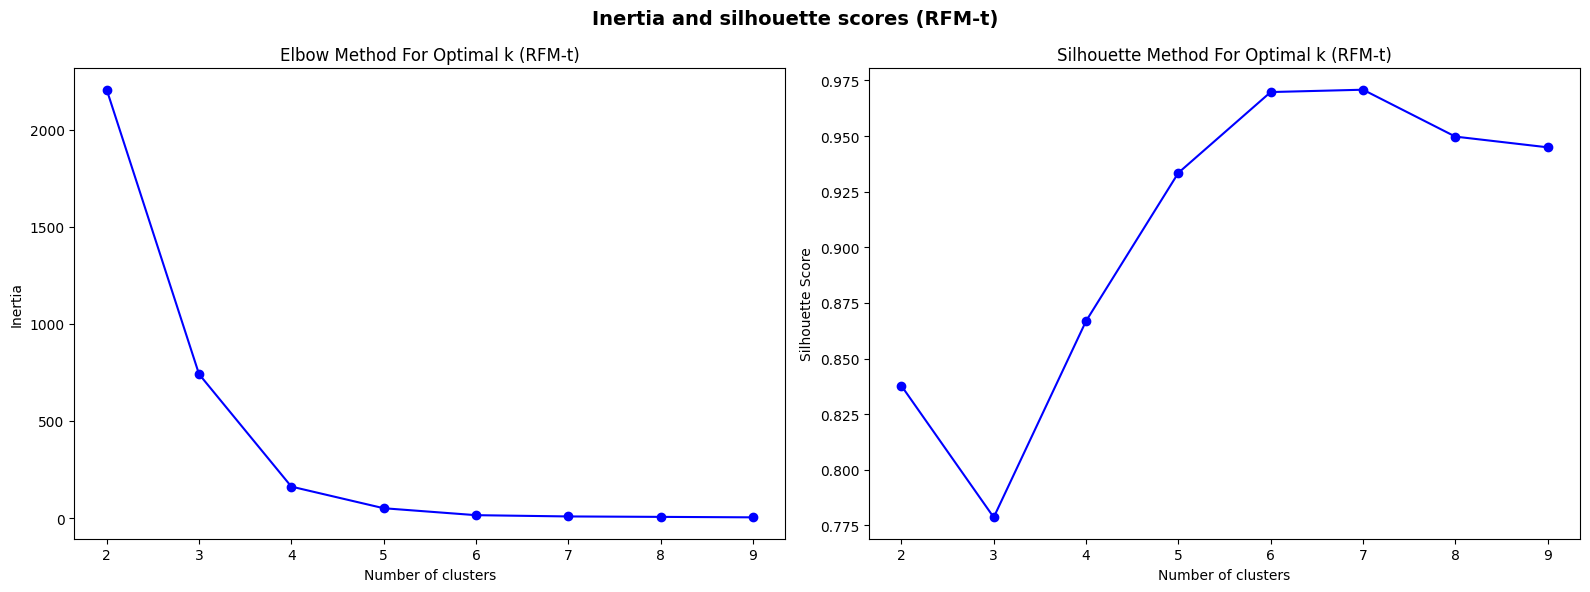

In [39]:
inertia(rfm_t_scale, 't')

For n_clusters = 6, the average silhouette_score is : 0.9697511802338261


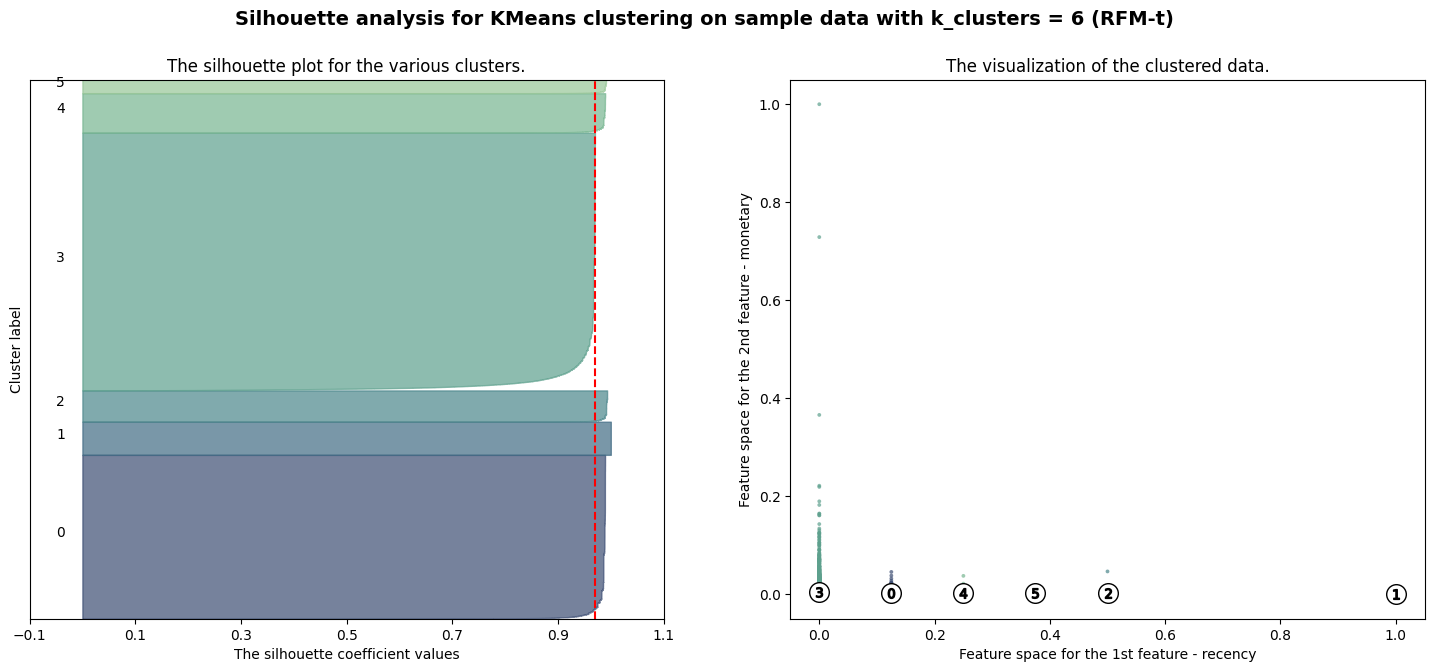

In [40]:
k=6
cluster_labels = drawing_graph(k, rfm_t_scale, 't')

In [41]:
# Assuming the optimal number of clusters is determined to be 5
# kmeans = KMeans(n_clusters=5, random_state=42)
rfm_t['cluster_t'] = cluster_labels
rfm_t_scale['cluster_t'] = rfm_t['cluster_t']
rfm_filled['cluster_t'] = rfm_t['cluster_t']

# Analyze clusters, e.g., calculate mean RFM values for each cluster
cluster_analysis = rfm_t.groupby('cluster_t').mean()

# Print cluster analysis results
print(cluster_analysis)

                     bid  recency_t  frequency_t    monetary_t
cluster_t                                                     
0           98090.140355        1.0     3.879188   5214.727273
1           45272.630974        8.0     0.000000      0.000000
2           66762.623722        4.0     2.717126   8783.433693
3          111952.163583        0.0     7.586086  24396.362249
4           80075.171530        2.0     3.825474   7301.158327
5           69534.431226        3.0     3.232399   9072.884615


C:\Users\seoye\AppData\Local\Temp\ipykernel_332\806020569.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_t['cluster_t'] = cluster_labels


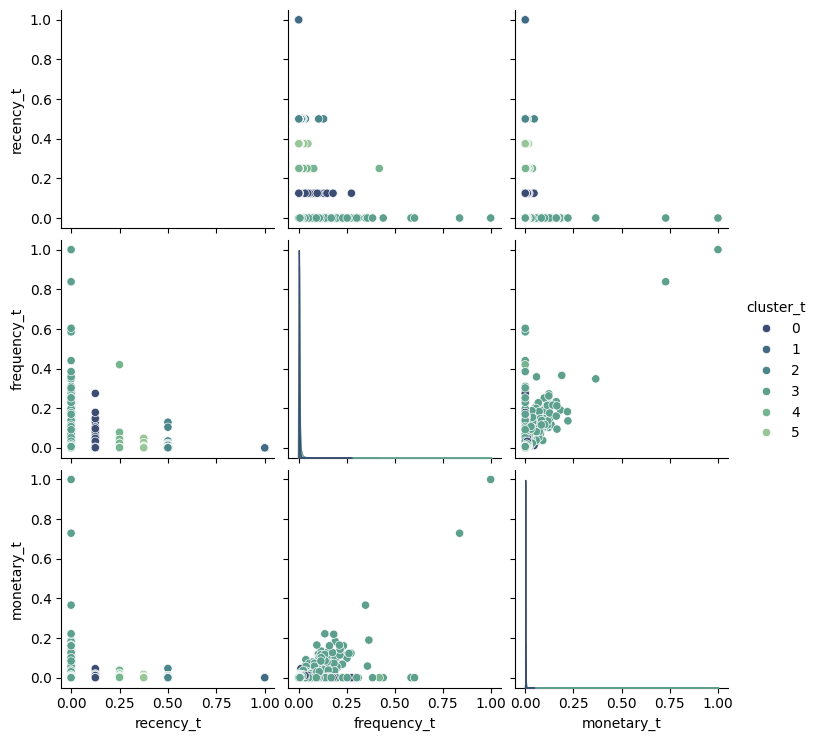

In [42]:

# Visualize clusters
sns.pairplot(rfm_t_scale, hue='cluster_t', vars=['recency_t', 'frequency_t', 'monetary_t'], palette=colors)
plt.show()

In [43]:
rfm_t

,bid,recency_t,frequency_t,monetary_t,cluster_t
0,3551.0,8.0,0.0,0.0,1
1,3552.0,8.0,0.0,0.0,1
2,3553.0,0.0,6.0,39600.0,3
3,3554.0,1.0,7.0,9000.0,0
4,3555.0,8.0,0.0,0.0,1
...,...,...,...,...,...
123165,161739.0,1.0,1.0,3500.0,0
123166,161740.0,0.0,2.0,0.0,3
123167,161741.0,0.0,2.0,7800.0,3
123168,161742.0,0.0,2.0,0.0,3


In [44]:
rfm_filled

,bid,recency_t,frequency_t,monetary_t,recency_fc,frequency_fc,monetary_fc,recency_ec,frequency_ec,monetary_ec,cluster_fc,cluster_ec,cluster_t
0,3551.0,8.0,0.0,0.0,8.0,0.0,0.0,2.0,5.0,52425.0,0,4,1
1,3552.0,8.0,0.0,0.0,8.0,0.0,0.0,2.0,23.0,283125.0,0,4,1
2,3553.0,0.0,6.0,39600.0,3.0,2.0,6540.0,3.0,11.0,63395.0,3,2,3
3,3554.0,1.0,7.0,9000.0,8.0,0.0,0.0,3.0,2.0,7306.0,0,2,0
4,3555.0,8.0,0.0,0.0,8.0,0.0,0.0,0.0,7.0,19805.0,0,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
123165,161739.0,1.0,1.0,3500.0,8.0,0.0,0.0,8.0,0.0,0.0,0,0,0
123166,161740.0,0.0,2.0,0.0,8.0,0.0,0.0,8.0,0.0,0.0,0,0,3
123167,161741.0,0.0,2.0,7800.0,8.0,0.0,0.0,8.0,0.0,0.0,0,0,3
123168,161742.0,0.0,2.0,0.0,8.0,0.0,0.0,8.0,0.0,0.0,0,0,3


In [45]:

rfm_filled.to_csv('data/data-trans/classification_rfm.csv', index=False)

In [ ]:
rfm_filled['cluster_fc'].value_counts()

cluster_fc
0    101816
4      8186
1      5599
3      5283
2      2285
Name: count, dtype: int64

In [51]:
rfm_filled['cluster_ec'].value_counts()

cluster_ec
0    118360
3      1775
2      1105
1       736
4       603
5       590
Name: count, dtype: int64

In [52]:
rfm_filled['cluster_t'].value_counts()

cluster_t
3    58918
0    37455
4     9013
1     7574
2     7141
5     3068
Name: count, dtype: int64

### Train/Test

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.model_selection import train_test_split, cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier

# Define models with increased max_iter for Logistic Regression
# models = {
#     "Logistic Regression": LogisticRegression(max_iter=1000000, solver='lbfgs'), #  'saga' or 'liblinear'
#     "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=10),
#     "XGBoost": XGBClassifier(eval_metric='mlogloss', use_label_encoder=False, eta=0.1),
#     "SVM": SVC(probability=True),
#     "KNN": KNeighborsClassifier(n_neighbors=5),
#     "DT": DecisionTreeClassifier(max_depth=10),
#     "GB": GradientBoostingClassifier(n_estimators=100, max_depth=5)
# }

In [2]:
rfm_filled = pd.read_csv('data/data-trans/classification_rfm.csv', low_memory=False)

In [3]:

# Data
X = rfm_filled[['recency_fc', 'frequency_fc', 'monetary_fc', 'recency_ec', 'frequency_ec', 'monetary_ec', 'recency_t', 'frequency_t', 'monetary_t']]
y = rfm_filled[['cluster_fc', 'cluster_ec', 'cluster_t']]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Classification

In [4]:
# Function to plot confusion matrices
def plot_confusion_matrix(y_true, y_pred, labels):
    fig, axes = plt.subplots(1, len(labels), figsize=(20, 5))
    for i, label in enumerate(labels):
        cm = confusion_matrix(y_true[:, i], y_pred[:, i])
        sns.heatmap(cm, annot=True, fmt='d', ax=axes[i], cmap='Blues')
        axes[i].set_title(f'Confusion Matrix: {label}')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')
    plt.show()

In [ ]:
def model_training(model_name, model):
    model_name = model_name
    model = MultiOutputClassifier(model)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    # Evaluate each output separately
    precision, recall, f1 = {}, {}, {}
    for i, column in enumerate(y.columns):
        p, r, f, _ = precision_recall_fscore_support(y_test[column], y_pred[:, i], average='macro')
        precision[column] = p
        recall[column] = r
        f1[column] = f

    subset_accuracy = (y_test == y_pred).all(axis=1).mean()
    print(f"Model: {model_name}")
    print(f"Subset Accuracy: {subset_accuracy}")

    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1: {f1}")

    print("\n"+"-"*60+"\n")

    # Accuracy for each cluster
    accuracy_fc = accuracy_score(y_test['cluster_fc'], y_pred[:, 0])
    accuracy_ec = accuracy_score(y_test['cluster_ec'], y_pred[:, 1])
    accuracy_t = accuracy_score(y_test['cluster_t'], y_pred[:, 2])
    print(f'Accuracy for cluster_fc: {accuracy_fc}')
    print(f'Accuracy for cluster_ec: {accuracy_ec}')
    print(f'Accuracy for cluster_t: {accuracy_t}')

    print("\n"+"-"*60+"\n")

    # Classification report for each output
    for i, column in enumerate(y.columns):
        print(f"Classification Report for {column}:")
        print(classification_report(y_test[column], y_pred[:, i], zero_division=0))


    # Plot confusion matrix
    plot_confusion_matrix(y_test.to_numpy(), y_pred, y.columns)


    print("\n" + "#"*60 + "\n")

##### logistic regression

c:\Users\seoye\Desktop\seoyeong\NCSU\Nagoya\nagoya-research\nagoya-venv\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\seoye\Desktop\seoyeong\NCSU\Nagoya\nagoya-research\nagoya-venv\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alterna

Model: Logistic regression
Subset Accuracy: 0.8915726232037022
Precision: {'cluster_fc': 0.6775345127055032, 'cluster_ec': 0.37407037271757204, 'cluster_t': 0.8253957964733191}
Recall: {'cluster_fc': 0.6704630280149233, 'cluster_ec': 0.4240844885540438, 'cluster_t': 0.8217021667358261}
F1: {'cluster_fc': 0.666690054899738, 'cluster_ec': 0.358941353097792, 'cluster_t': 0.799410816906757}

------------------------------------------------------------

Accuracy for cluster_fc: 0.9355362507104003
Accuracy for cluster_ec: 0.9783226435008525
Accuracy for cluster_t: 0.9680522854591216

------------------------------------------------------------

Classification Report for cluster_fc:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20307
           1       0.48      0.28      0.36      1134
           2       0.51      0.44      0.47       460
           3       0.74      0.83      0.78      1088
           4       0.66      0.80      0.72 

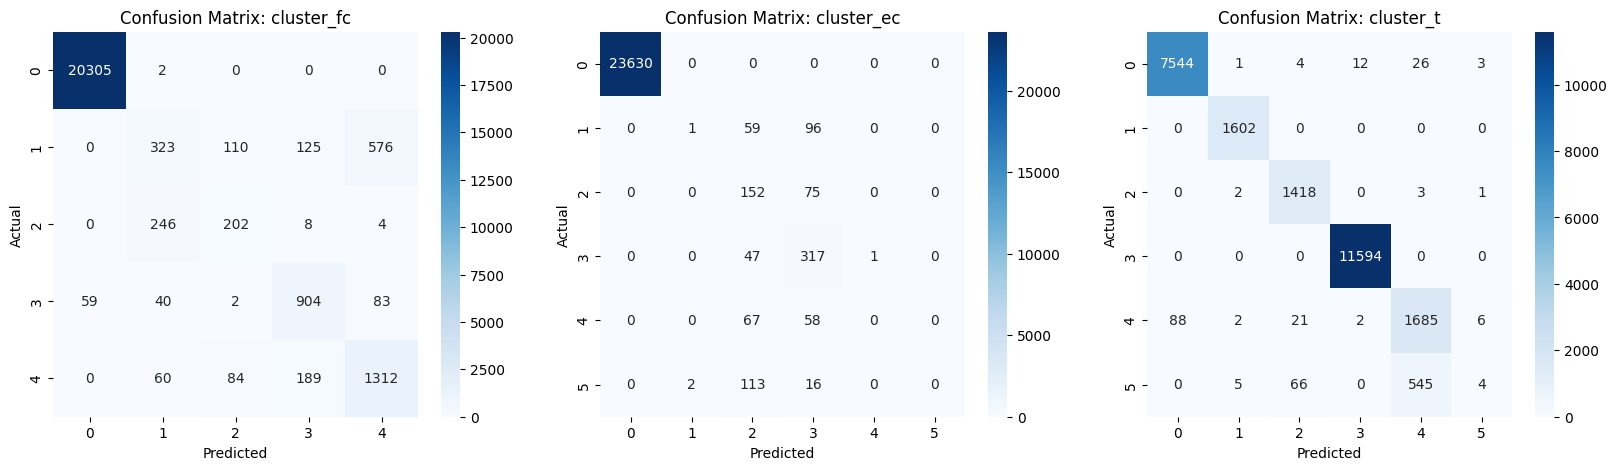


############################################################



In [5]:
model_training('Logistic regression', LogisticRegression(max_iter=1000000, solver='lbfgs'))


##### Random forest

c:\Users\seoye\Desktop\seoyeong\NCSU\Nagoya\nagoya-research\nagoya-venv\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model: Random forest
Subset Accuracy: 0.9570918243078672
Precision: {'cluster_fc': 0.9958042124961809, 'cluster_ec': 0.9673839506742317, 'cluster_t': 0.7723666241601584}
Recall: {'cluster_fc': 0.9903404646882908, 'cluster_ec': 0.9396746264761532, 'cluster_t': 0.7903735041563899}
F1: {'cluster_fc': 0.9929530491798768, 'cluster_ec': 0.9488560589500058, 'cluster_t': 0.7811127025899239}

------------------------------------------------------------

Accuracy for cluster_fc: 0.9990257367865552
Accuracy for cluster_ec: 0.9980920678736706
Accuracy for cluster_t: 0.9596492652431599

------------------------------------------------------------

Classification Report for cluster_fc:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20307
           1       0.98      1.00      0.99      1134
           2       1.00      0.95      0.98       460
           3       1.00      1.00      1.00      1088
           4       1.00      1.00      1.00     

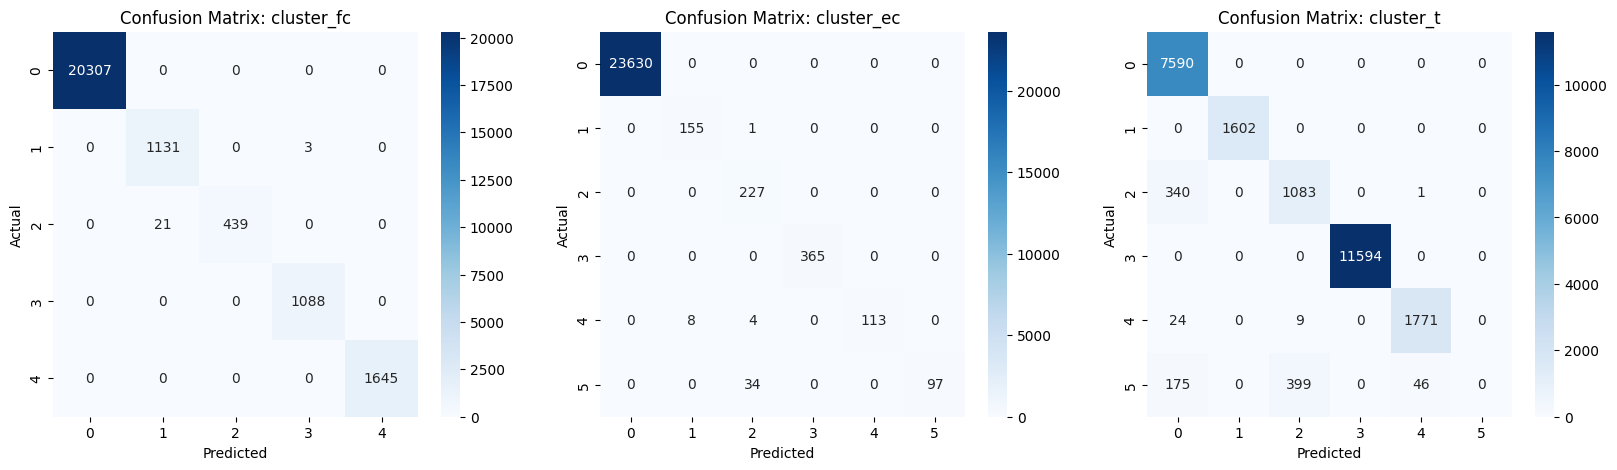


############################################################



In [6]:
model_training('Random forest', RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_split=5, min_samples_leaf=5))

##### XGBoost

Model: XGBoost
Subset Accuracy: 1.0
Precision: {'cluster_fc': 1.0, 'cluster_ec': 1.0, 'cluster_t': 1.0}
Recall: {'cluster_fc': 1.0, 'cluster_ec': 1.0, 'cluster_t': 1.0}
F1: {'cluster_fc': 1.0, 'cluster_ec': 1.0, 'cluster_t': 1.0}

------------------------------------------------------------

Accuracy for cluster_fc: 1.0
Accuracy for cluster_ec: 1.0
Accuracy for cluster_t: 1.0

------------------------------------------------------------

Classification Report for cluster_fc:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20307
           1       1.00      1.00      1.00      1134
           2       1.00      1.00      1.00       460
           3       1.00      1.00      1.00      1088
           4       1.00      1.00      1.00      1645

    accuracy                           1.00     24634
   macro avg       1.00      1.00      1.00     24634
weighted avg       1.00      1.00      1.00     24634

Classification Report for clust

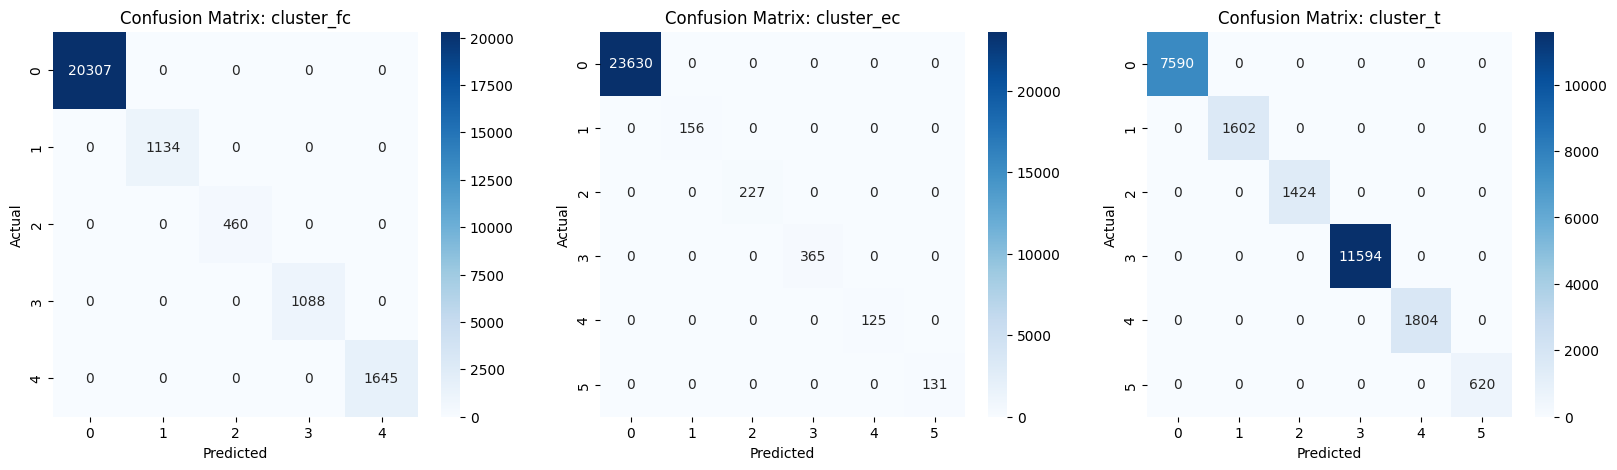


############################################################



In [7]:
model_training('XGBoost', XGBClassifier(eval_metric='mlogloss', eta=0.01, n_estimators=100, max_depth=5, min_child_weight=5))

##### Gradient boosting

Model: Gradient boosting
Subset Accuracy: 0.9999188113988796
Precision: {'cluster_fc': 0.9996478873239436, 'cluster_ec': 1.0, 'cluster_t': 1.0}
Recall: {'cluster_fc': 0.9991304347826088, 'cluster_ec': 1.0, 'cluster_t': 1.0}
F1: {'cluster_fc': 0.9993880586987609, 'cluster_ec': 1.0, 'cluster_t': 1.0}

------------------------------------------------------------

Accuracy for cluster_fc: 0.9999188113988796
Accuracy for cluster_ec: 1.0
Accuracy for cluster_t: 1.0

------------------------------------------------------------

Classification Report for cluster_fc:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20307
           1       1.00      1.00      1.00      1134
           2       1.00      1.00      1.00       460
           3       1.00      1.00      1.00      1088
           4       1.00      1.00      1.00      1645

    accuracy                           1.00     24634
   macro avg       1.00      1.00      1.00     24634
w

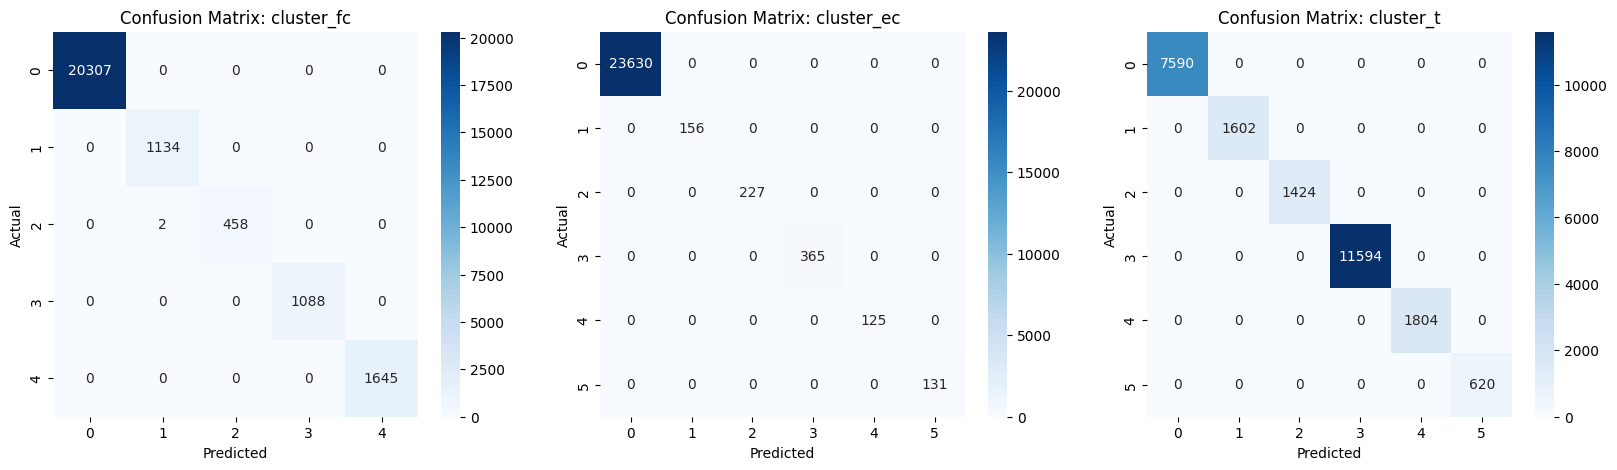


############################################################



In [8]:
model_training('Gradient boosting', GradientBoostingClassifier(n_estimators=10, max_depth=3, min_samples_split=3, min_samples_leaf=3))

##### SVM

c:\Users\seoye\Desktop\seoyeong\NCSU\Nagoya\nagoya-research\nagoya-venv\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\seoye\Desktop\seoyeong\NCSU\Nagoya\nagoya-research\nagoya-venv\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\seoye\Desktop\seoyeong\NCSU\Nagoya\nagoya-research\nagoya-venv\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` paramete

Model: SVM
Subset Accuracy: 0.4241698465535439
Precision: {'cluster_fc': 0.5115811116394824, 'cluster_ec': 0.2768001431234794, 'cluster_t': 0.20602993461512856}
Recall: {'cluster_fc': 0.4789777310243091, 'cluster_ec': 0.29689516555455736, 'cluster_t': 0.21380060402617596}
F1: {'cluster_fc': 0.4843865747564645, 'cluster_ec': 0.25441709492989933, 'cluster_t': 0.17754334907080727}

------------------------------------------------------------

Accuracy for cluster_fc: 0.8843874320045466
Accuracy for cluster_ec: 0.9707315092960949
Accuracy for cluster_t: 0.4865226922140132

------------------------------------------------------------

Classification Report for cluster_fc:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     20307
           1       0.46      0.24      0.32      1134
           2       0.73      0.58      0.65       460
           3       0.00      0.00      0.00      1088
           4       0.42      0.57      0.49      1645

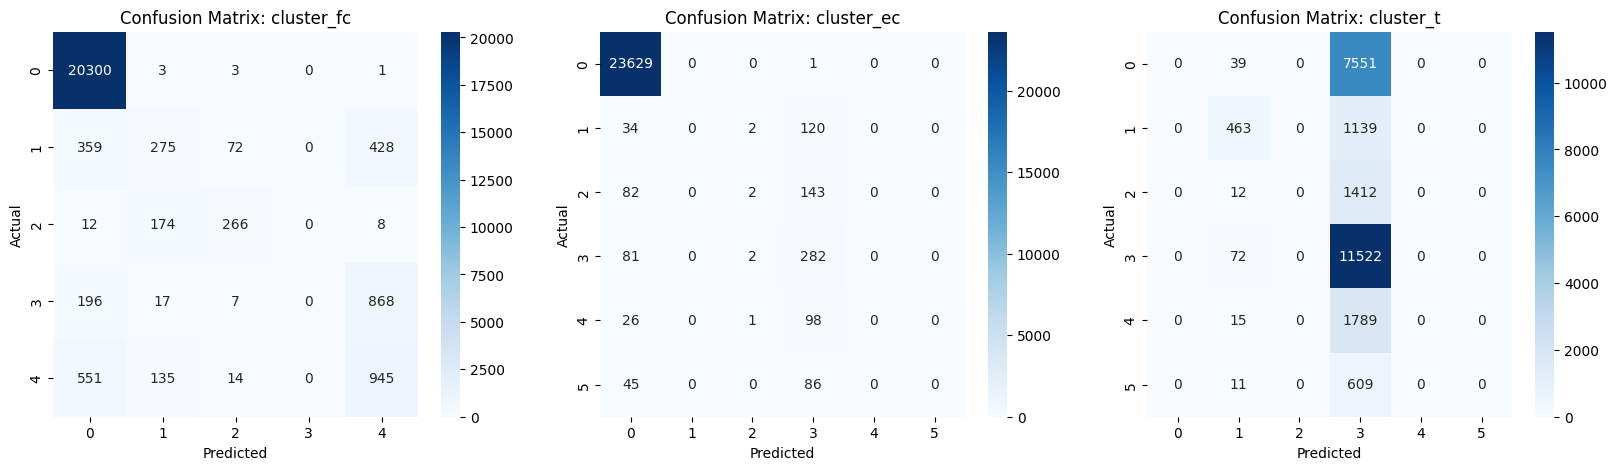


############################################################



In [11]:
model_training('SVM', SVC(probability=True))

##### KNN

Model: KNN
Subset Accuracy: 0.9136559227084518
Precision: {'cluster_fc': 0.8602297588037704, 'cluster_ec': 0.43214765815076955, 'cluster_t': 0.9557470766307364}
Recall: {'cluster_fc': 0.8270079420295608, 'cluster_ec': 0.39512321278211804, 'cluster_t': 0.9195011049317552}
F1: {'cluster_fc': 0.8428646633263887, 'cluster_ec': 0.4031126928323295, 'cluster_t': 0.9362340057633336}

------------------------------------------------------------

Accuracy for cluster_fc: 0.9634245351952586
Accuracy for cluster_ec: 0.9727206300235447
Accuracy for cluster_t: 0.9531541771535277

------------------------------------------------------------

Classification Report for cluster_fc:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     20307
           1       0.78      0.78      0.78      1134
           2       0.78      0.73      0.75       460
           3       0.91      0.81      0.85      1088
           4       0.85      0.82      0.84      1645

 

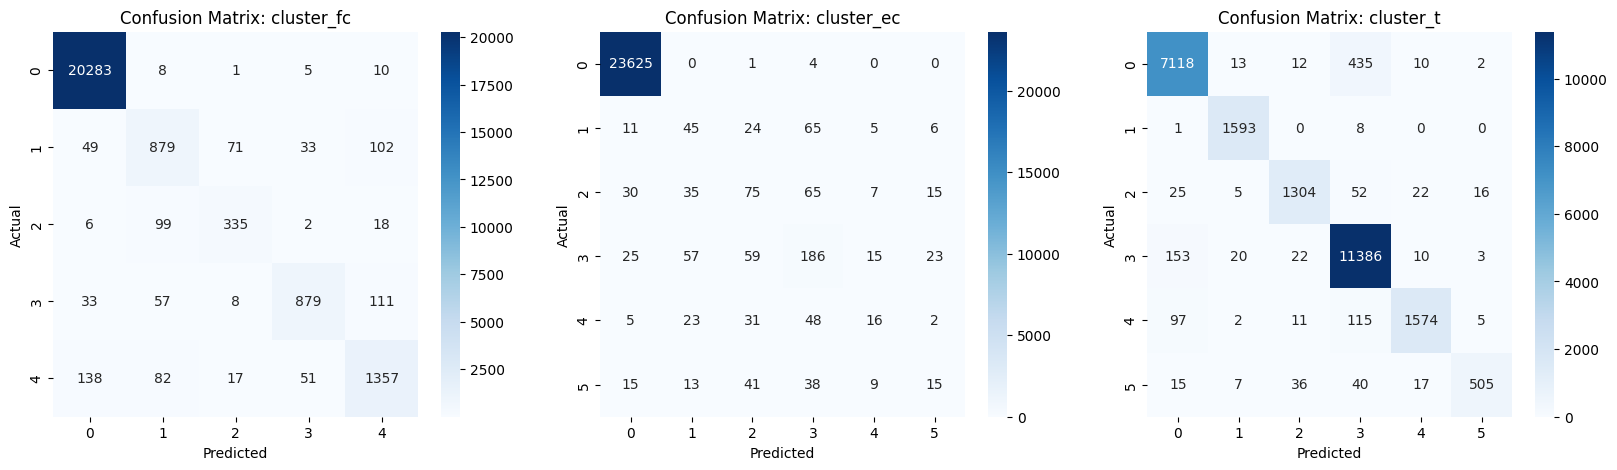


############################################################



In [10]:
model_training('KNN', KNeighborsClassifier(n_neighbors=5))

##### Decision tree

c:\Users\seoye\Desktop\seoyeong\NCSU\Nagoya\nagoya-research\nagoya-venv\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\seoye\Desktop\seoyeong\NCSU\Nagoya\nagoya-research\nagoya-venv\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model: Decision tree
Subset Accuracy: 0.904441016481286
Precision: {'cluster_fc': 0.9787234042553191, 'cluster_ec': 0.5315397257732095, 'cluster_t': 0.5732309380142623}
Recall: {'cluster_fc': 0.9739290281329922, 'cluster_ec': 0.6666666666666666, 'cluster_t': 0.6666666666666666}
F1: {'cluster_fc': 0.9749634263838152, 'cluster_ec': 0.5816711976895043, 'cluster_t': 0.6017530487804877}

------------------------------------------------------------

Accuracy for cluster_fc: 0.9945197694243728
Accuracy for cluster_ec: 0.9896078590565884
Accuracy for cluster_t: 0.9170252496549485

------------------------------------------------------------

Classification Report for cluster_fc:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20307
           1       0.89      1.00      0.94      1134
           2       1.00      0.99      0.99       460
           3       1.00      0.88      0.94      1088
           4       1.00      1.00      1.00      

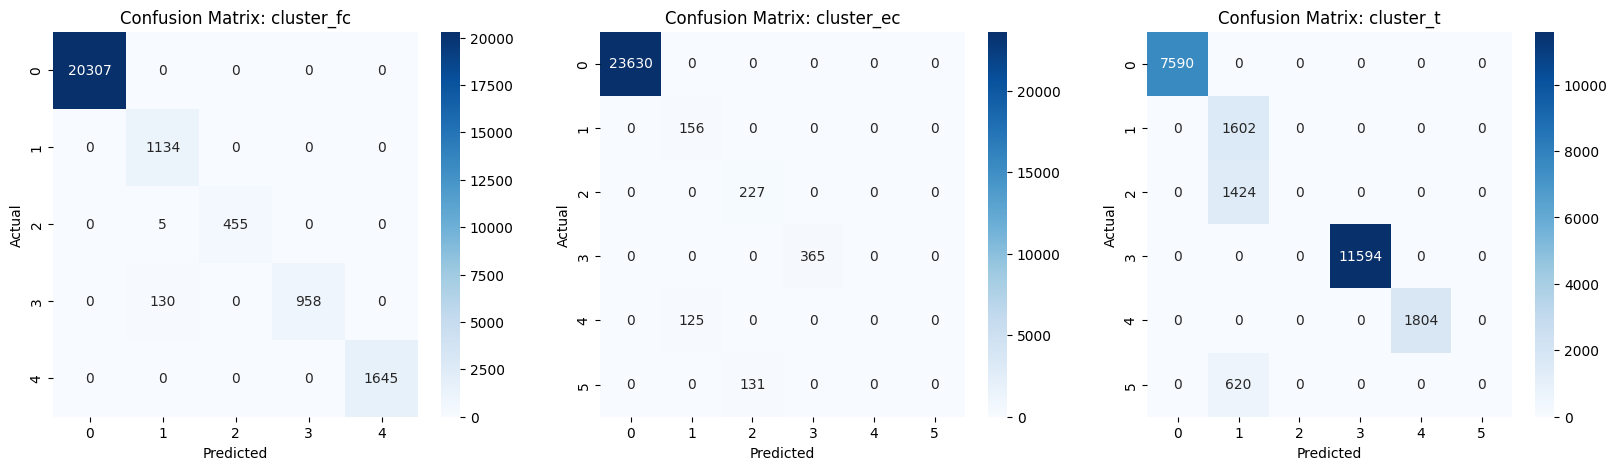


############################################################



In [9]:
model_training('Decision tree',DecisionTreeClassifier(max_depth=3, min_samples_split=3, min_samples_leaf=3))

In [13]:

# for model_name, base_model in models.items():
#     model = MultiOutputClassifier(base_model)
#     model.fit(X_train, y_train)
    
#     y_pred = model.predict(X_test)
    
#     # Evaluate each output separately
#     precision, recall, f1 = {}, {}, {}
#     for i, column in enumerate(y.columns):
#         p, r, f, _ = precision_recall_fscore_support(y_test[column], y_pred[:, i], average='macro')
#         precision[column] = p
#         recall[column] = r
#         f1[column] = f
    
#     subset_accuracy = (y_test == y_pred).all(axis=1).mean()
#     print(f"Model: {model_name}")
#     print(f"Subset Accuracy: {subset_accuracy}")

#     print("\n"+"-"*60+"\n")
    
#     # Accuracy for each cluster
#     accuracy_fc = accuracy_score(y_test['cluster_fc'], y_pred[:, 0])
#     accuracy_ec = accuracy_score(y_test['cluster_ec'], y_pred[:, 1])
#     accuracy_t = accuracy_score(y_test['cluster_t'], y_pred[:, 2])
#     print(f'Accuracy for cluster_fc: {accuracy_fc}')
#     print(f'Accuracy for cluster_ec: {accuracy_ec}')
#     print(f'Accuracy for cluster_t: {accuracy_t}')

#     print("\n"+"-"*60+"\n")
    
#     # Classification report for each output
#     for i, column in enumerate(y.columns):
#         print(f"Classification Report for {column}:")
#         print(classification_report(y_test[column], y_pred[:, i], zero_division=0))
    
    
#     # Cross-validation
#     # cross_val_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
#     # print(f"Cross-validation Accuracy: {cross_val_scores.mean()} (std: {cross_val_scores.std()})")
    
#     # Plot confusion matrix
#     plot_confusion_matrix(y_test.to_numpy(), y_pred, y.columns)
    
    
#     print("\n" + "#"*60 + "\n")